## Task 1: Principal Component Analysis (PCA)
This section focuses on dimensionality reduction, moving from high-dimensional data to a 2D space for visualization and efficiency while maintaining the integrity of the information.

### 1. Load or Create a Dataset
We will use the Wine Dataset, which has 13 features (dimensions). This is more complex than a simple 2D or 3D plot and allows us to see the power of PCA.

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Load data
wine = load_wine()
X = wine.data
y = wine.target

# PCA is sensitive to scaling, so we must standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original shape: {X.shape}")

Original shape: (178, 13)


### 2. Find the First 2 Principal Components (Manual vs. Scikit-Learn)

#### Manual Method (Eigendecomposition)

To compute without scikit-learn:
1. Calculate the Covariance Matrix
2. Find the Eigenvectors (directions of maximum variance)
3. Project the data onto the eigenvectors

In [3]:
# A) WITHOUT SKLEARN (Manual)
# 1. Compute covariance matrix
cov_matrix = np.cov(X_scaled.T)

# 2. Get eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("eigenvectors:", eigenvectors)
print("eigenvalues:", eigenvalues)


# 3. Sort eigenvectors by eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]
eigenvectors = eigenvectors[:, idx]
print("sorted eigenvectors:", eigenvectors)

# 4. Project data onto the first 2 eigenvectors
X_pca_manual = X_scaled.dot(eigenvectors[:, :2])

# B) WITH SKLEARN
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


X_pca_sklearn = pca.fit_transform(X_scaled)
print("Sklearn PCA:", X_pca_sklearn)

print("Manual PCA shape:", X_pca_manual.shape)
print("Sklearn PCA shape:", X_pca_sklearn.shape)

eigenvectors: [[-0.1443294   0.48365155  0.20738262 -0.0178563  -0.26566365  0.21353865
   0.05639636 -0.01496997  0.39613926 -0.26628645 -0.50861912 -0.22591696
   0.21160473]
 [ 0.24518758  0.22493093 -0.08901289  0.53689028  0.03521363  0.53681385
  -0.42052391 -0.02596375  0.06582674  0.12169604  0.07528304  0.07648554
  -0.30907994]
 [ 0.00205106  0.31606881 -0.6262239  -0.21417556 -0.14302547  0.15447466
   0.14917061  0.14121803 -0.17026002 -0.04962237  0.30769445 -0.49869142
  -0.02712539]
 [ 0.23932041 -0.0105905  -0.61208035  0.06085941  0.06610294 -0.10082451
   0.28696914 -0.09168285  0.42797018 -0.05574287 -0.20044931  0.47931378
   0.05279942]
 [-0.14199204  0.299634   -0.13075693 -0.35179658  0.72704851  0.03814394
  -0.3228833  -0.05677422 -0.15636143  0.06222011 -0.27140257  0.07128891
   0.06787022]
 [-0.39466085  0.06503951 -0.14617896  0.19806835 -0.14931841 -0.0841223
   0.02792498  0.46390791 -0.40593409 -0.30388245 -0.28603452  0.30434119
  -0.32013135]
 [-0.4229

### 3. Preserving a Certain Percentage of Variance

Instead of selecting a fixed number of components (e.g., 2), PCA can be configured to retain enough components to explain a specified percentage of the data's variance, such as 95%.

In [4]:
pca_95 = PCA(n_components=0.95)
X_reduced_95 = pca_95.fit_transform(X_scaled)

print(f"Components needed for 95% variance: {pca_95.n_components_}")

Components needed for 95% variance: 10


### 4. Train a Neural Network: Original vs. PCA

We use a Multi-Layer Perceptron (MLP) to compare model performance on the original dataset versus the PCA-transformed dataset.

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split original data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# a) Original Dataset
mlp_orig = MLPClassifier(max_iter=500, random_state=42)
mlp_orig.fit(X_train, y_train)
acc_orig = accuracy_score(y_test, mlp_orig.predict(X_test))

# b) PCA Components (using the 2 components found earlier)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_sklearn, y, test_size=0.2, random_state=42)
mlp_pca = MLPClassifier(max_iter=500, random_state=42)
mlp_pca.fit(X_train_pca, y_train_pca)
acc_pca = accuracy_score(y_test_pca, mlp_pca.predict(X_test_pca))

print(f"Accuracy (Original - 13 features): {acc_orig:.4f}")
print(f"Accuracy (PCA - 2 features): {acc_pca:.4f}")

Accuracy (Original - 13 features): 1.0000
Accuracy (PCA - 2 features): 1.0000


### 5. Kernel PCA (Linear, Sigmoid, RBF)

Standard PCA captures only linear relationships. Kernel PCA applies the kernel trick to identify non-linear patterns, using kernels such as Linear, Sigmoid, and RBF.

In [6]:
from sklearn.decomposition import KernelPCA

# List of kernels to iterate through
# 'linear' is equivalent to standard PCA
# 'sigmoid' is inspired by neural networks
# 'rbf' (Radial Basis Function) is great for circular/complex clusters
kernels = ["linear", "sigmoid", "rbf"]

for k in kernels:
    # 1. Initialize KernelPCA with 2 components and the current kernel
    kpca = KernelPCA(n_components=2, kernel=k)
    X_kpca = kpca.fit_transform(X_scaled)

    # 2. Split the newly transformed data into training and testing sets
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
        X_kpca, y, test_size=0.2, random_state=42
    )

    # 3. Initialize and train the MLP Classifier on the KPCA-transformed data
    # We increase max_iter to ensure the network converges
    mlp_k = MLPClassifier(max_iter=1000, random_state=42).fit(X_train_k, y_train_k)

    # 4. Predict and print the results
    predictions = mlp_k.predict(X_test_k)
    accuracy = accuracy_score(y_test_k, predictions)
    print(f"Kernel: {k:8} | Accuracy: {accuracy:.4f}")

Kernel: linear   | Accuracy: 1.0000
Kernel: sigmoid  | Accuracy: 1.0000
Kernel: rbf      | Accuracy: 1.0000


### 6. Hyperparameter Tuning Pipeline

We implement a Pipeline combined with GridSearchCV to simultaneously optimize the kernel selection and neural network hyperparameters.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# 1. Define the Pipeline
# This sequences the steps: First apply KPCA, then feed the result into the MLP
pipeline = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("mlp", MLPClassifier(max_iter=1000, random_state=42))
])

# 2. Define the Parameter Grid
# Note the naming convention: 'stepname__parametername'
param_grid = {
    # Tuning KPCA: testing different kernels and the gamma (influence) parameter
    "kpca__kernel": ["linear", "rbf", "sigmoid"],
    "kpca__gamma": [0.01, 0.1, 1],

    # Tuning the Neural Network: testing different architectures and activations
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50)], # Try 1 or 2 hidden layers
    "mlp__activation": ["relu", "tanh"] # Relu is standard, Tanh is often good for scaled data
}

# 3. Initialize GridSearchCV
# cv=3 means 3-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1) # n_jobs=-1 uses all CPU cores

# 4. Run the search on the scaled data
grid_search.fit(X_scaled, y)

# 5. Output the best combination found
print("Best Parameters Found:")
print(grid_search.best_params_)

# 6. Output the best score achieved during training
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

Best Parameters Found:
{'kpca__gamma': 0.1, 'kpca__kernel': 'rbf', 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50, 50)}
Best Cross-Validation Accuracy: 0.9719


## Task 2: Classification with Keras

**IRIS vs. Fashion MNIST**: IRIS is a "toy" dataset (150 samples, 4 features) where deep learning is often overkill. Fashion MNIST (70,000 images) is the real test for your Neural Network.

**One-Hot Encoding**: For IRIS, because we used `categorical_crossentropy`, we had to transform the label `2` into `[0, 0, 1]`. For Fashion MNIST, we used `sparse_categorical_crossentropy`, which allows us to keep labels as integers.

**Callbacks**: These are your safety net. `EarlyStopping` prevents your model from "memorizing" (overfitting) the training data by halting training when the test loss starts to increase.

### 1. Load IRIS and Fashion MNIST
While Fashion MNIST is a standard Keras dataset, the IRIS dataset is usually loaded via sklearn or pandas and then converted for Keras.

In [8]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

# A) Load IRIS
iris = load_iris()
X_iris = iris.data
y_iris = iris.target.reshape(-1, 1)

# Preprocess IRIS: Scale features and One-Hot encode labels for the NN
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
encoder = OneHotEncoder(sparse_output=False)
y_iris_cat = encoder.fit_transform(y_iris)

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris_scaled, y_iris_cat, test_size=0.2, random_state=42
)

# B) Load Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_f, y_train_f), (X_test_f, y_test_f) = fashion_mnist.load_data()

# Preprocess Fashion MNIST: Scale to [0, 1] and Flatten (for a simple Dense NN)
X_train_f = X_train_f / 255.0
X_test_f = X_test_f / 255.0

### 2. Build and Train the Neural Network
We'll create a function to build the model so we can reuse it for tuning.

In [9]:
def build_simple_model(input_shape, num_classes, hidden_size=64, activation='relu'):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(hidden_size, activation=activation),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy' if num_classes > 2 else 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Training on Fashion MNIST (as it's more complex)
# Note: Using sparse_categorical_crossentropy because labels are integers (0-9)
model_f = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), #28*28=784 long 1D array
    keras.layers.Dense(128, activation='relu'), #all 128 neurons are connected to the flattened
    keras.layers.Dense(10, activation='softmax') #has 10 categories of T-shirts etc
])

model_f.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model_f.fit(X_train_f, y_train_f, epochs=10,
                    validation_data=(X_test_f, y_test_f), verbose=1)

/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8270 - loss: 0.4947 - val_accuracy: 0.8456 - val_loss: 0.4284
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8660 - loss: 0.3721 - val_accuracy: 0.8586 - val_loss: 0.3884
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8779 - loss: 0.3330 - val_accuracy: 0.8646 - val_loss: 0.3772
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8883 - loss: 0.3065 - val_accuracy: 0.8720 - val_loss: 0.3553
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8918 - loss: 0.2910 - val_accuracy: 0.8784 - val_loss: 0.3433
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8976 - loss: 0.2765 - val_accuracy: 0.8797 - val_loss: 0.3414
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9012 - loss: 0.2654 - val_accuracy: 0.8820 - val_loss: 0.3413
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9055 - loss: 0.2525 - 

### 3. Hyperparameter Tuning (What else can be tuned?)

Beyond `hidden_layer_sizes` and `activation`, you can tune:

- **Optimizer**: Adam, SGD, RMSprop
- **Learning Rate**: One of the most critical parameters
- **Batch Size**: 32, 64, 128 (impacts stability and speed)
- **Dropout Rate**: To prevent overfitting
- **Regularization (L1/L2)**: Penalizes large weights

### 4. Plot Loss and Accuracy
Visualizing the history object is key to spotting overfitting.

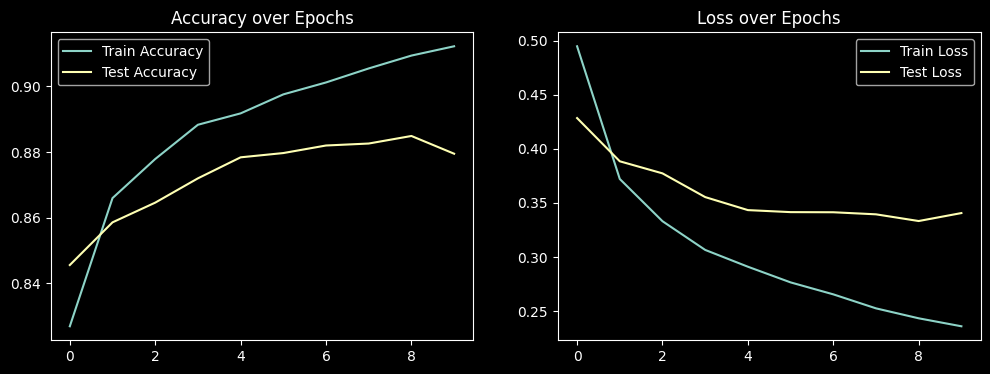

In [11]:
def plot_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

plot_history(history)

### Reduce the overfitting

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8024 - loss: 0.5688 - val_accuracy: 0.8462 - val_loss: 0.4329
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8539 - loss: 0.4100 - val_accuracy: 0.8541 - val_loss: 0.4106
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8666 - loss: 0.3705 - val_accuracy: 0.8663 - val_loss: 0.3734
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8755 - loss: 0.3451 - val_accuracy: 0.8703 - val_loss: 0.3597
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8799 - loss: 0.3295 - val_accuracy: 0.8639 - val_loss: 0.3706
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8851 - loss: 0.3176 - val_accuracy: 0.8771 - val_loss: 0.3408
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8883 - loss: 0.3058 - val_accuracy: 0.8756 - val_loss: 0.3437
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8924 - loss: 0.2953 - 

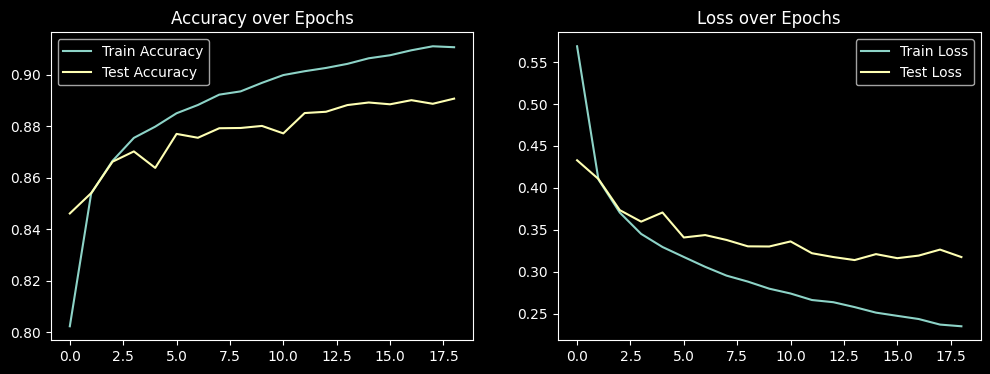

In [12]:
from tensorflow import keras

# 1. Re-build the model with a Dropout layer
model_improved = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    # Dropout randomly sets 20% of input units to 0 at each step during training
    # This prevents the model from relying too heavily on specific pixels/features
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# 2. Configure a custom Learning Rate
# Reducing the learning rate (e.g., to 0.0005) helps the model converge more stably
custom_optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model_improved.compile(
    optimizer=custom_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Train again (using more epochs to let EarlyStopping)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_improved = model_improved.fit(
    X_train_f, y_train_f,
    epochs=30,
    validation_data=(X_test_f, y_test_f),
    callbacks=[early_stopping_cb]
)

# 4. Visualize the new results
plot_history(history_improved)

In [13]:
# Save the final improved weights separately as requested in Step 5
model_improved.save_weights("task2_final_weights.weights.h5")

# Save the full model as requested in Step 6
model_improved.save("task2_fashion_mnist_model.keras")

print("Weights and Model saved successfully.")

# Practice Loading
from tensorflow.keras.models import load_model
reloaded_model = load_model("task2_fashion_mnist_model.keras")

# Quick check
test_loss, test_acc = reloaded_model.evaluate(X_test_f, y_test_f, verbose=0)
print(f"Verified Reloaded Model Accuracy: {test_acc:.4f}")

Weights and Model saved successfully.
Verified Reloaded Model Accuracy: 0.8883


### 5. Callbacks and Saving Weights
Callbacks allow the model to "do things" during training, like saving only the best version of itself.

In [14]:
# Define callbacks
# ModelCheckpoint: Saves weights during training
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_best_weights.weights.h5",
                                                 save_best_only=True,
                                                 save_weights_only=True)

# EarlyStopping: Stops training if the model stops improving
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Re-train with callbacks
model_f.fit(X_train_f, y_train_f, epochs=20,
            validation_data=(X_test_f, y_test_f),
            callbacks=[checkpoint_cb, early_stopping_cb])

# Manually save weights
model_f.save_weights("final_weights.weights.h5")

Epoch 1/20
  28/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9252 - loss: 0.2235

2026-02-04 10:34:56.673164: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 188160000 exceeds 10% of free system memory.


1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9163 - loss: 0.2260

2026-02-04 10:35:08.508619: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9144 - loss: 0.2306 - val_accuracy: 0.8881 - val_loss: 0.3364
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9165 - loss: 0.2220 - val_accuracy: 0.8831 - val_loss: 0.3384
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9198 - loss: 0.2156 - val_accuracy: 0.8902 - val_loss: 0.3394
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9213 - loss: 0.2094 - val_accuracy: 0.8891 - val_loss: 0.3409
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9249 - loss: 0.2020 - val_accuracy: 0.8898 - val_loss: 0.3377
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9258 - loss: 0.1970 - val_accuracy: 0.8850 - val_loss: 0.3463


### 6. Saving and Loading the Full Model
This saves the architecture, weights, AND optimizer state.

In [15]:
# Save the entire model
model_f.save("my_fashion_model.keras")

# Load it back
loaded_model = keras.models.load_model("my_fashion_model.keras")

# Verify by evaluating
loss, acc = loaded_model.evaluate(X_test_f, y_test_f, verbose=0)
print(f"Loaded model accuracy: {acc:.4f}")

2026-02-04 10:37:08.013519: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 31360000 exceeds 10% of free system memory.


Loaded model accuracy: 0.8881


## Task 3: Regression with California Housing

### 1. Load and Split the Dataset
The California housing dataset contains features like median income and house age to predict the median house value.

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load data
housing = fetch_california_housing()

# 2. Split into training and testing (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, test_size=0.2, random_state=42
)

# 3. Create a validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# 4. Scale the features (essential for Neural Networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(f"Training shape: {X_train.shape}")

Training shape: (13209, 8)


### 2. Build and Train the Neural Network
For regression, we use Mean Squared Error (MSE) as the loss function. The output layer has 1 neuron with no activation function to allow it to predict any continuous value.

In [17]:
import tensorflow as tf
from tensorflow import keras

# Build the model
model = keras.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1) # Output layer for regression (no activation)
])

# Compile with Mean Squared Error (MSE)
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["mean_absolute_error"])

# Train the model
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3686 - mean_absolute_error: 0.8188 - val_loss: 0.5944 - val_mean_absolute_error: 0.5550
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4823 - mean_absolute_error: 0.4978 - val_loss: 0.4398 - val_mean_absolute_error: 0.4794
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4025 - mean_absolute_error: 0.4518 - val_loss: 0.4276 - val_mean_absolute_error: 0.4602
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3853 - mean_absolute_error: 0.4395 - val_loss: 0.4263 - val_mean_absolute_error: 0.4568
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3697 - mean_absolute_error: 0.4318 - val_loss: 0.3917 - val_mean_absolute_error: 0.4473
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3581 - mean_absolute_error: 0.4247 - val_loss: 0.3794 - val_mean_absolute_error: 0.4368
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3496 - mean_absolute_error: 0.4192 - val_loss: 0.

### 3. Plot the Network History

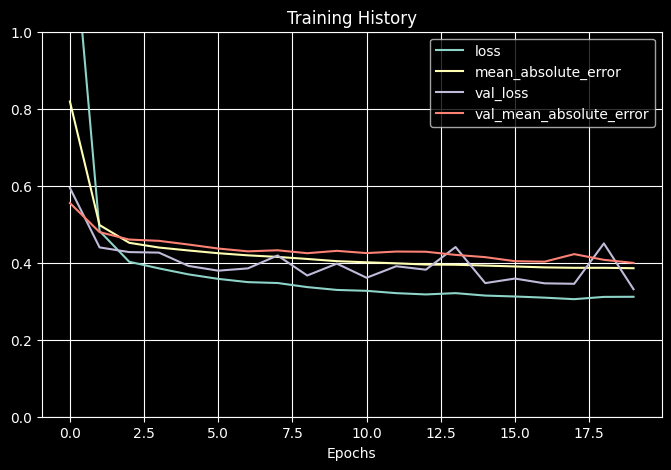

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_regression_history(history, title="Training History"):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # MSE usually drops quickly
    plt.title(title)
    plt.xlabel("Epochs")
    plt.show()

plot_regression_history(history)

### 4. Change Learning Rate and Compare
Changing the learning rate is one of the most impactful tuning steps. A rate too high causes the model to diverge; a rate too low makes it take forever to learn.

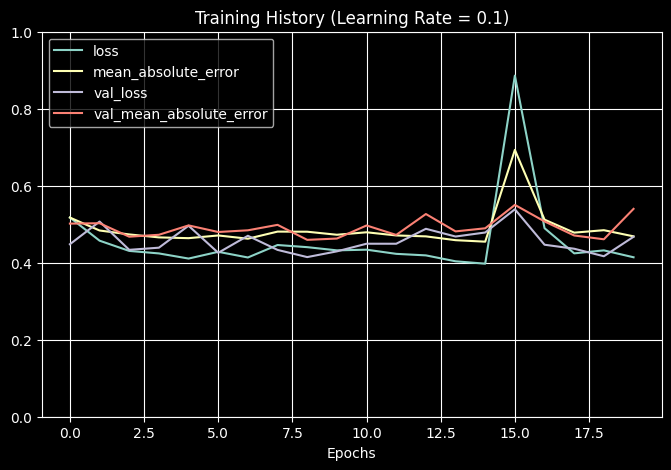

In [19]:
# Create a new model instance to reset weights
model_lr = keras.models.clone_model(model)

# Compile with a much higher learning rate (e.g., 0.1)
model_lr.compile(loss="mean_squared_error",
                 optimizer=keras.optimizers.Adam(learning_rate=0.1))

# Train again
history_lr = model_lr.fit(X_train, y_train, epochs=20,
                          validation_data=(X_valid, y_valid), verbose=0)

plot_regression_history(history_lr, title="Training History (Learning Rate = 0.1)")

# Discussion: Usually, 0.1 is too high for Adam on this dataset,
# and you'll see the loss "jump" around or fail to decrease.

### 5. Callbacks and Saving Weights

In [20]:
# Define Checkpoint to save best weights
checkpoint_cb = keras.callbacks.ModelCheckpoint("housing_weights.weights.h5",
                                                 save_best_only=True,
                                                 save_weights_only=True)

# Early Stopping stops training when the validation loss hasn't improved for 5 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train with callbacks
history_final = model.fit(X_train, y_train, epochs=50,
                          validation_data=(X_valid, y_valid),
                          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3019 - mean_absolute_error: 0.3825 - val_loss: 0.3352 - val_mean_absolute_error: 0.4037
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3011 - mean_absolute_error: 0.3822 - val_loss: 0.3410 - val_mean_absolute_error: 0.4004
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3022 - mean_absolute_error: 0.3816 - val_loss: 0.3556 - val_mean_absolute_error: 0.4115
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3022 - mean_absolute_error: 0.3808 - val_loss: 0.3623 - val_mean_absolute_error: 0.3949
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2975 - mean_absolute_error: 0.3797 - val_loss: 0.3508 - val_mean_absolute_error: 0.4047
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2958 - mean_absolute_error: 0.3789 - val_loss: 0.3225 - val_mean_absolute_error: 0.3883
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2958 - mean_absolute_error: 0.3787 - v

### 6. Save and Load the Model

In [21]:
# Save the full model (Architecture + Weights + Optimizer state)
model.save("california_housing_model.keras")

# Load the model
loaded_model = keras.models.load_model("california_housing_model.keras")

# Test prediction
sample_data = X_test[:3]
predictions = loaded_model.predict(sample_data)
print("Predictions:", predictions)
print("Actual values:", y_test[:3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predictions: [[0.5558232]
 [1.1588995]
 [4.5814066]]
Actual values: [0.477   0.458   5.00001]
